## Importing Libraries

In [ ]:
import re
import nltk
import pandas as pd
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import joblib


from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/sentiment_data/trainingandtestdata

/content/drive/MyDrive/sentiment_data/trainingandtestdata


In [ ]:
ls

glove_embeddings/                               testdata.manual.2009.06.14.csv
logistic_regression_model_with_cleaning.pkl     tfidf_vectorizer.pkl
logistic_regression_model_without_cleaning.pkl  tfidf_vectorizer_with_cleaning.pkl
lr_model.pkl                                    tfidf_vectorizer_without_cleaning.pkl
svc_model.pkl                                   training.1600000.processed.noemoticon.csv


In [ ]:
# Load the training and test datasets
train_file_path = 'training.1600000.processed.noemoticon.csv'
test_file_path = 'testdata.manual.2009.06.14.csv'

# The training dataset does not have a header
train_columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
train_data = pd.read_csv(train_file_path, names=train_columns, encoding='latin1')

# The test dataset does not have a header
test_columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
test_data = pd.read_csv(test_file_path, names=test_columns, encoding='latin1')

# Display the first few rows of each dataset
print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())


Training Data:
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Test Data:
   target  ids                          date     flag      user  \
0       4    3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1       4    4  

### Cleaning the text with links and stop words

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

### Lets see the distribution in the training data

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

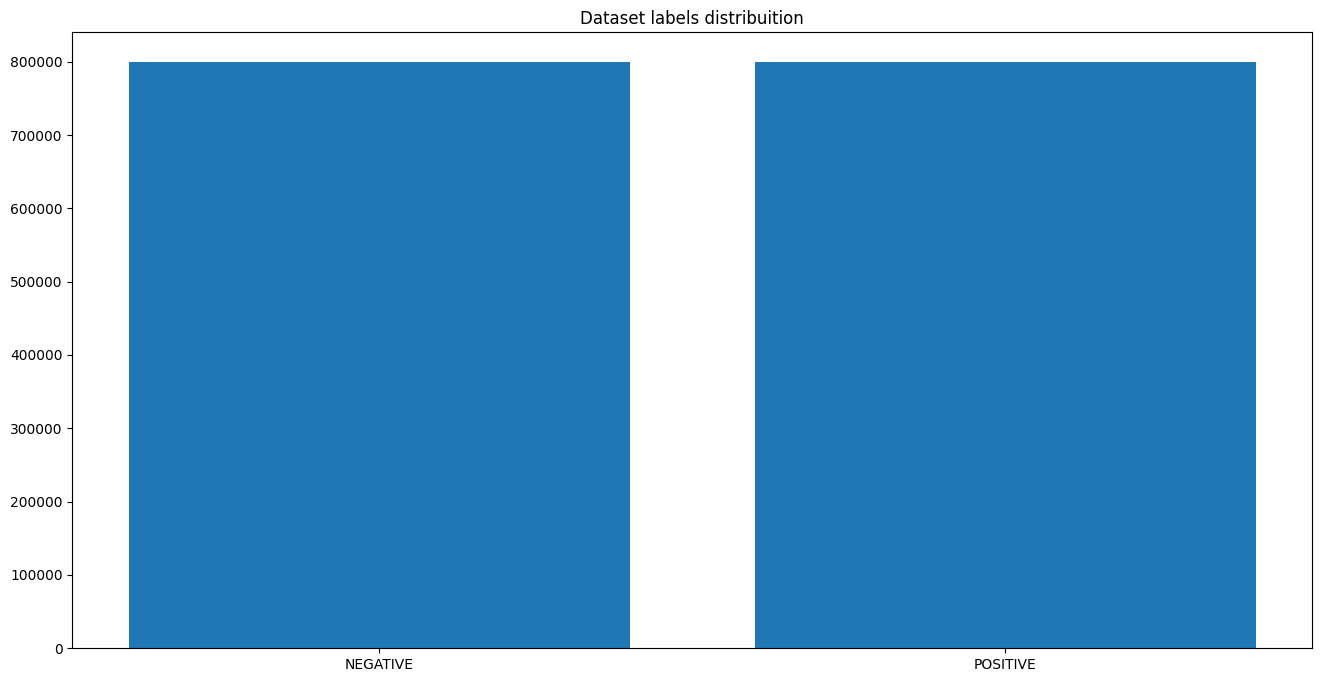

In [ ]:
train_data.target = train_data.target.apply(lambda x: decode_sentiment(x))
target_cnt = Counter(train_data.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

There are no neutral sentiment words present

In [ ]:
random_idx_list = [random.randint(1,len(train_data.text)) for i in range(10)] # creates random indexes to choose from dataframe
train_data.loc[random_idx_list,:].head(10)

,target,ids,date,flag,user,text
1410135,POSITIVE,2056225182,Sat Jun 06 10:45:19 PDT 2009,NO_QUERY,Valdyr,im lot happier day
58497,NEGATIVE,1685914157,Sun May 03 02:45:13 PDT 2009,NO_QUERY,hortovanyi,think work might easier buy expens well
891790,POSITIVE,1690944182,Sun May 03 16:44:14 PDT 2009,NO_QUERY,ijcopon925,yeah get one come visit
245153,NEGATIVE,1981943542,Sun May 31 10:12:28 PDT 2009,NO_QUERY,loismererid,successful day revis french sun catch slight t...
739322,NEGATIVE,2265699036,Sun Jun 21 07:07:58 PDT 2009,NO_QUERY,CaitlynMcCoy,hit butterfli
1019569,POSITIVE,1882213967,Fri May 22 06:27:18 PDT 2009,NO_QUERY,jdap,ok tend use dongl nice know could even nicer k...
598531,NEGATIVE,2219551888,Thu Jun 18 00:48:16 PDT 2009,NO_QUERY,jellybones_,feel sorri self lol
1162077,POSITIVE,1979560284,Sun May 31 03:34:25 PDT 2009,NO_QUERY,MrSaints,lol sure
887801,POSITIVE,1687097265,Sun May 03 07:45:25 PDT 2009,NO_QUERY,zmaslowski,bagel thera even norma jean suck enough reason...
352703,NEGATIVE,2031268439,Thu Jun 04 09:34:33 PDT 2009,NO_QUERY,junelynanne,tri rewrit cover letter doesnt sound gener thi...


### Common words in positive and negative sentences

In [ ]:
positive_words = []
negative_words = []
neutral_words = []

for i, row in train_data.iterrows():
    if row['target'] == 'POSITIVE':
        positive_words.extend(row['text'].split())
    elif row['target'] == 'NEGATIVE':
        negative_words.extend(row['text'].split())
    elif row['target'] == 'NEUTRAL':
        neutral_words.extend(row['text'].split())

# Count word frequencies
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)
neutral_word_counts = Counter(neutral_words)

# Get the most common positive, negative, and neutral words
common_positive_words = [word for word, count in positive_word_counts.most_common(10000)]
common_negative_words = [word for word, count in negative_word_counts.most_common(10000)]
common_neutral_words = [word for word, count in neutral_word_counts.most_common(10000)]

print("Common positive words:", common_positive_words)
print("Common negative words:", common_negative_words)
print("Common neutral words:", common_neutral_words)


Common positive words: ['im', 'good', 'love', 'go', 'day', 'thank', 'get', 'like', 'lol', 'time', 'got', 'u', 'today', 'see', 'work', 'one', 'know', 'new', 'watch', 'great', 'well', 'think', 'hope', 'back', 'night', 'amp', 'dont', 'look', 'make', 'haha', 'twitter', 'happi', 'morn', 'follow', 'cant', 'come', 'wait', 'realli', 'fun', 'ill', 'that', 'nice', 'want', 'much', 'need', 'oh', 'na', 'home', 'tomorrow', 'awesom', 'feel', 'still', 'your', 'hey', 'say', 'friend', 'last', 'would', 'tweet', 'way', 'thing', 'right', 'ye', 'better', 'tonight', 'yeah', 'take', 'tri', 'week', 'best', 'guy', 'sleep', 'gon', 'final', 'let', 'enjoy', 'everyon', 'movi', 'cool', 'yay', 'start', 'peopl', 'show', 'play', 'use', 'weekend', 'ive', 'first', 'bed', 'sure', 'song', 'next', 'miss', 'excit', 'amaz', 'soon', 'though', 'girl', 'even', 'pleas', 'lt', 'littl', 'ok', 'done', 'alway', 'ur', 'glad', 'life', 'x', 'listen', 'read', 'lot', 'sound', 'could', 'us', 'made', 'readi', 'pretti', 'birthday', 'check', 

### Positive Word Cloud

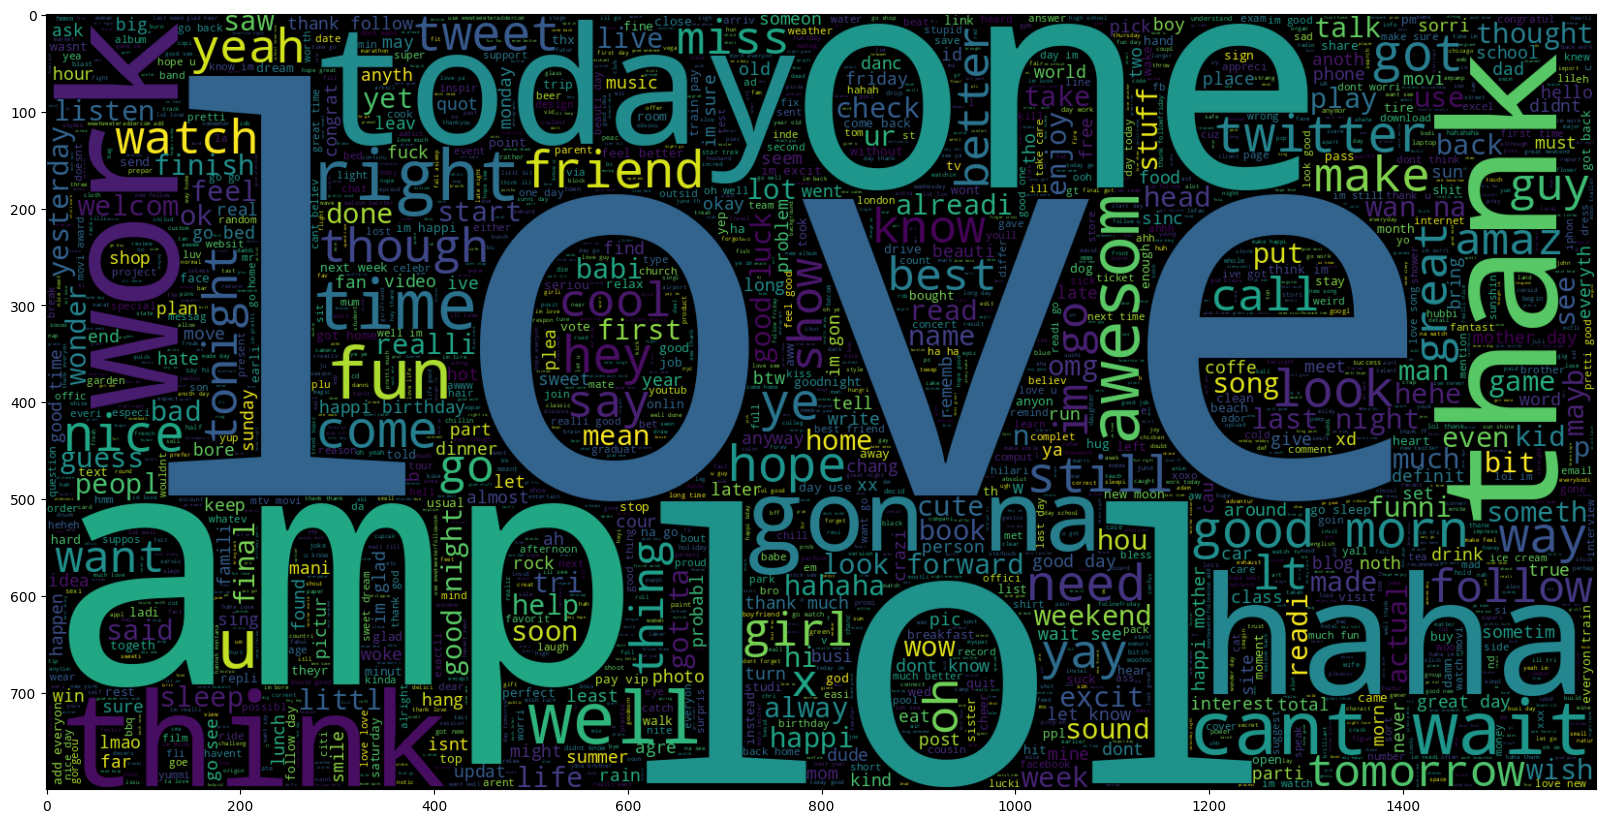

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_data[train_data.target == 'POSITIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Word Cloud

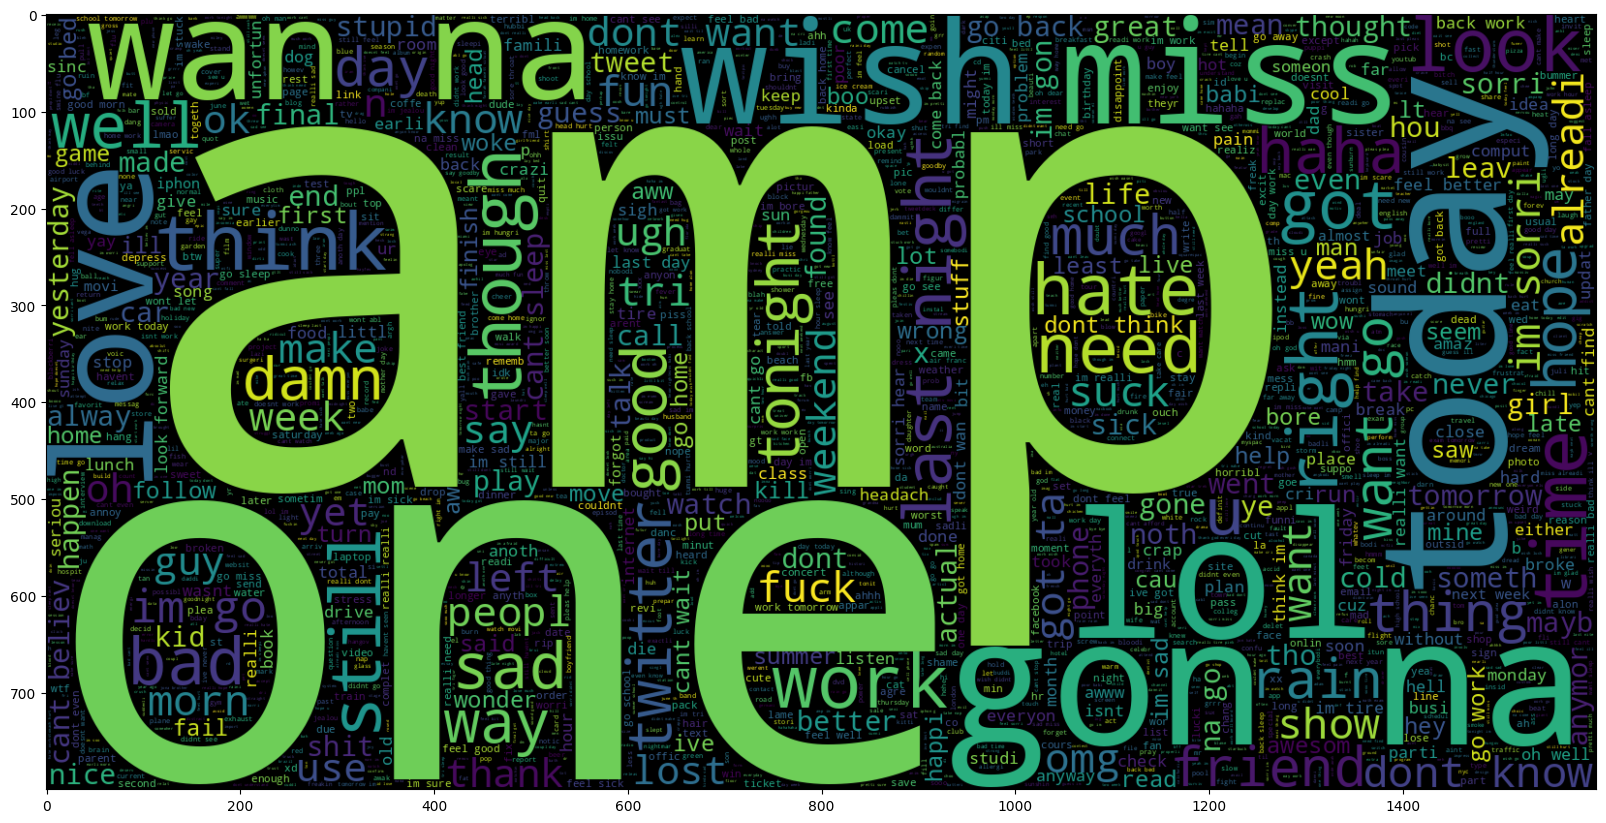

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_data[train_data.target == 'NEGATIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Checks Negative and Positive words in the text

In [ ]:
# Ensure you have downloaded the necessary datasets
nltk.download('opinion_lexicon')
nltk.download('punkt')

# Load positive and negative words from the opinion lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def detect_sentiment_words(words):
    positive_detected = [word for word in words if word in positive_words]
    negative_detected = [word for word in words if word in negative_words]
    return positive_detected, negative_detected



[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Labelling Sentences Neutral based on Positive and Negative words

In [ ]:
# Function to label neutral tweets
def label_neutral(text):
    positive_detected, negative_detected = detect_sentiment_words(text.split())
    if not positive_detected and not negative_detected:
        return 'NEUTRAL'
    return None


# Label neutral tweets in the training data
train_data['target'] = train_data.apply(
    lambda row: label_neutral(row['text']) if label_neutral(row['text']) is not None else row['target'], axis=1
)

# Print the new distribution of labels
print("New distribution of labels in the subset training data:")
print(train_data['target'].value_counts())


New distribution of labels in the subset training data:
target
NEUTRAL     647170
NEGATIVE    499410
POSITIVE    453420
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
processed_text = train_data['text']
sentiment = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment, test_size=0.05, random_state=0)

### TF-IDF Vectorization

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')

Vectoriser fitted.


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

### Training models on the train_test_split data

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.81      0.81     24847
     NEUTRAL       0.98      1.00      0.99     32504
    POSITIVE       0.80      0.79      0.79     22649

    accuracy                           0.88     80000
   macro avg       0.87      0.87      0.87     80000
weighted avg       0.88      0.88      0.88     80000



### Validating trained models on test data which has neutral sentiment as well

In [ ]:
test_data['target'] = test_data['target'].map(decode_map)

In [ ]:
test_data

,target,ids,date,flag,user,text
0,POSITIVE,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,POSITIVE,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,POSITIVE,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,POSITIVE,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,POSITIVE,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,NEUTRAL,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,NEGATIVE,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,POSITIVE,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,NEGATIVE,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [ ]:
def model_test_evaluate(model, X_test, y_test):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

In [ ]:
X_test_vectorized = vectoriser.transform(test_data["text"])
model_test_evaluate(LRmodel, X_test_vectorized, test_data['target'])

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.49      0.59       177
     NEUTRAL       0.48      0.85      0.61       139
    POSITIVE       0.74      0.54      0.62       182

    accuracy                           0.61       498
   macro avg       0.65      0.63      0.61       498
weighted avg       0.66      0.61      0.61       498



Logistic Regression working better then the others

### Saving Weights

In [54]:
joblib.dump(LRmodel, 'lr_model.pkl')
joblib.dump(vectoriser, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
loaded_model = joblib.load('lr_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [ ]:
### Evaluate on test data
model_test_evaluate(loaded_model, X_test_vectorized, test_data['target'])

### Running on a sentence

In [ ]:
def predict_sentiment(sentence):
    # Preprocess the sentence
    cleaned_sentence = preprocess_text(sentence)
    # Vectorize the sentence
    vectorized_sentence = loaded_vectorizer.transform([cleaned_sentence])
    # Predict the sentiment
    prediction = loaded_model.predict(vectorized_sentence)
    return prediction[0]

In [ ]:
example_sentence = "I hate the rain."
predicted_sentiment = predict_sentiment(example_sentence)
print(f"Predicted sentiment for '{example_sentence}': {predicted_sentiment}")

Predicted sentiment for 'I hate the rain.': NEGATIVE


In [ ]:
def predict_sentiment(sentence):
    # Preprocess the sentence
    cleaned_sentence = preprocess_text(sentence)
    # Vectorize the sentence
    vectorized_sentence = vectoriser.transform([cleaned_sentence])
    # Predict the sentiment
    prediction = LRmodel.predict(vectorized_sentence)
    return prediction[0]

In [ ]:

example_sentence = "The day is okay"
predicted_sentiment = predict_sentiment(example_sentence)
print(f"Predicted sentiment for '{example_sentence}': {predicted_sentiment}")

Predicted sentiment for 'The day is okay': NEUTRAL


In [ ]:

example_sentence = "It is a great day"
predicted_sentiment = predict_sentiment(example_sentence)
print(f"Predicted sentiment for '{example_sentence}': {predicted_sentiment}")

Predicted sentiment for 'It is a great day': POSITIVE
